<a href="https://colab.research.google.com/github/martinpius/keras_Functional_API_architecture/blob/main/Aliens_Training_loop_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are using google colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n...Please Load Your Drive...")
def time_fmt(t):
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"{h}: {m:>03}: {s:>05.2f}"
time_fmt(125.8970)

Mounted at /content/drive/
You are using google colab with tensorflow version: 2.4.0


'0: 002: 05.00'

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import time
import numpy as np

In [5]:
#Training loop from scratch is necessary when implementing your own archtecture with desired features that are not 
#Part of the inbuilts functions (keras method---)
#As a simple example consider a mlp for mnist dataset

Model: "mlp_mnist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist_imgs (InputLayer)      [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


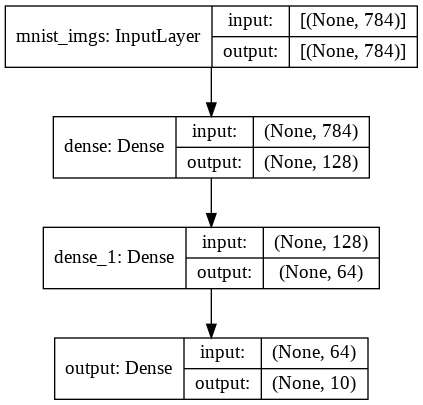

In [6]:
inputs = tf.keras.Input(shape = (784,), name = 'mnist_imgs')
x = layers.Dense(units = 128, activation = 'relu', kernel_initializer = 'random_normal')(inputs)
x = layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'random_normal')(x)
outputs = layers.Dense(units = 10, activation = 'softmax', name = 'output')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'mlp_mnist')
model.summary()
tf.keras.utils.plot_model(model = model, to_file = 'mlp_mnist.png', show_shapes = True)

In [7]:
#Loading and pre-process mnist data

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train.reshape(60000,784).astype('float32')/255.0, x_test.reshape(10000, 784).astype('float32')/255.0

11493376/11490434 [==============================] - 0s 0us/step


In [9]:
y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes = 10), tf.keras.utils.to_categorical(y_test, num_classes = 10)

In [10]:
train_dfm = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dfm = train_dfm.shuffle(buffer_size = 1024).batch(64)
test_dfm = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [11]:
#Getting the loss fn, metric fun to tracking the loss and the optimizer to update the weights
loss_fn = tf.keras.losses.CategoricalCrossentropy()
metric_fn = tf.keras.metrics.CategoricalAccuracy()
val_metric = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3)

In [12]:
#The training loop from scratch:
epochs = 5
tic = time.time()
for epoch in range(epochs):
  print(f"The start of epoch: {epoch}")
  for step, (x_train_batch, y_train_batch) in enumerate(train_dfm):
    with tf.GradientTape() as tape:
      output = model(x_train_batch,training = True)
      loss = loss_fn(y_train_batch, output)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    metric_fn.update_state(y_train_batch,output)
    train_acc = metric_fn.result()
    metric_fn.reset_states()
    if step % 100 ==0:
      print(f"train accuracy at epoch: {epoch} is :{float(train_acc): .4f}")
      print("at step %d:loss = %.4f" % (step, float(loss)))
  
  for step, (x_val_batch, y_val_batch) in enumerate(test_dfm):
    val_logits = model(x_val_batch, training = False)
    val_metric.update_state(y_val_batch, val_logits)
    val_acc = val_metric.result()
    val_metric.reset_states()
    if step % 200 == 0:
      print(f"validation accuracy is:{val_acc}")

toc = time.time()
print(f"Time elapsed is {time_fmt(toc - tic)}")



The start of epoch: 0
train accuracy at epoch: 0 is : 0.1250
at step 0:loss = 2.2881
train accuracy at epoch: 0 is : 0.9062
at step 100:loss = 0.2652
train accuracy at epoch: 0 is : 0.9062
at step 200:loss = 0.3463
train accuracy at epoch: 0 is : 0.9219
at step 300:loss = 0.2909
train accuracy at epoch: 0 is : 0.9062
at step 400:loss = 0.2307
train accuracy at epoch: 0 is : 0.9062
at step 500:loss = 0.3625
train accuracy at epoch: 0 is : 0.9219
at step 600:loss = 0.1961
train accuracy at epoch: 0 is : 1.0000
at step 700:loss = 0.0470
train accuracy at epoch: 0 is : 0.9844
at step 800:loss = 0.1272
train accuracy at epoch: 0 is : 0.9219
at step 900:loss = 0.1438
validation accuracy is:0.953125
The start of epoch: 1
train accuracy at epoch: 1 is : 0.9688
at step 0:loss = 0.1807
train accuracy at epoch: 1 is : 0.9531
at step 100:loss = 0.1412
train accuracy at epoch: 1 is : 0.9062
at step 200:loss = 0.2214
train accuracy at epoch: 1 is : 0.9375
at step 300:loss = 0.2010
train accuracy at 

In [1]:
#Lets speed_up the training by eargely excecution (using the tf.function decorator)

In [2]:
#Construct a simple Resnet for cifar10 data

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mnist_img (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 14, 14, 128)  1280        mnist_img[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 7, 7, 64)     73792       conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 4, 4, 32)     18464       conv2d_25[0][0]                  
_____________________________________________________________________________________________

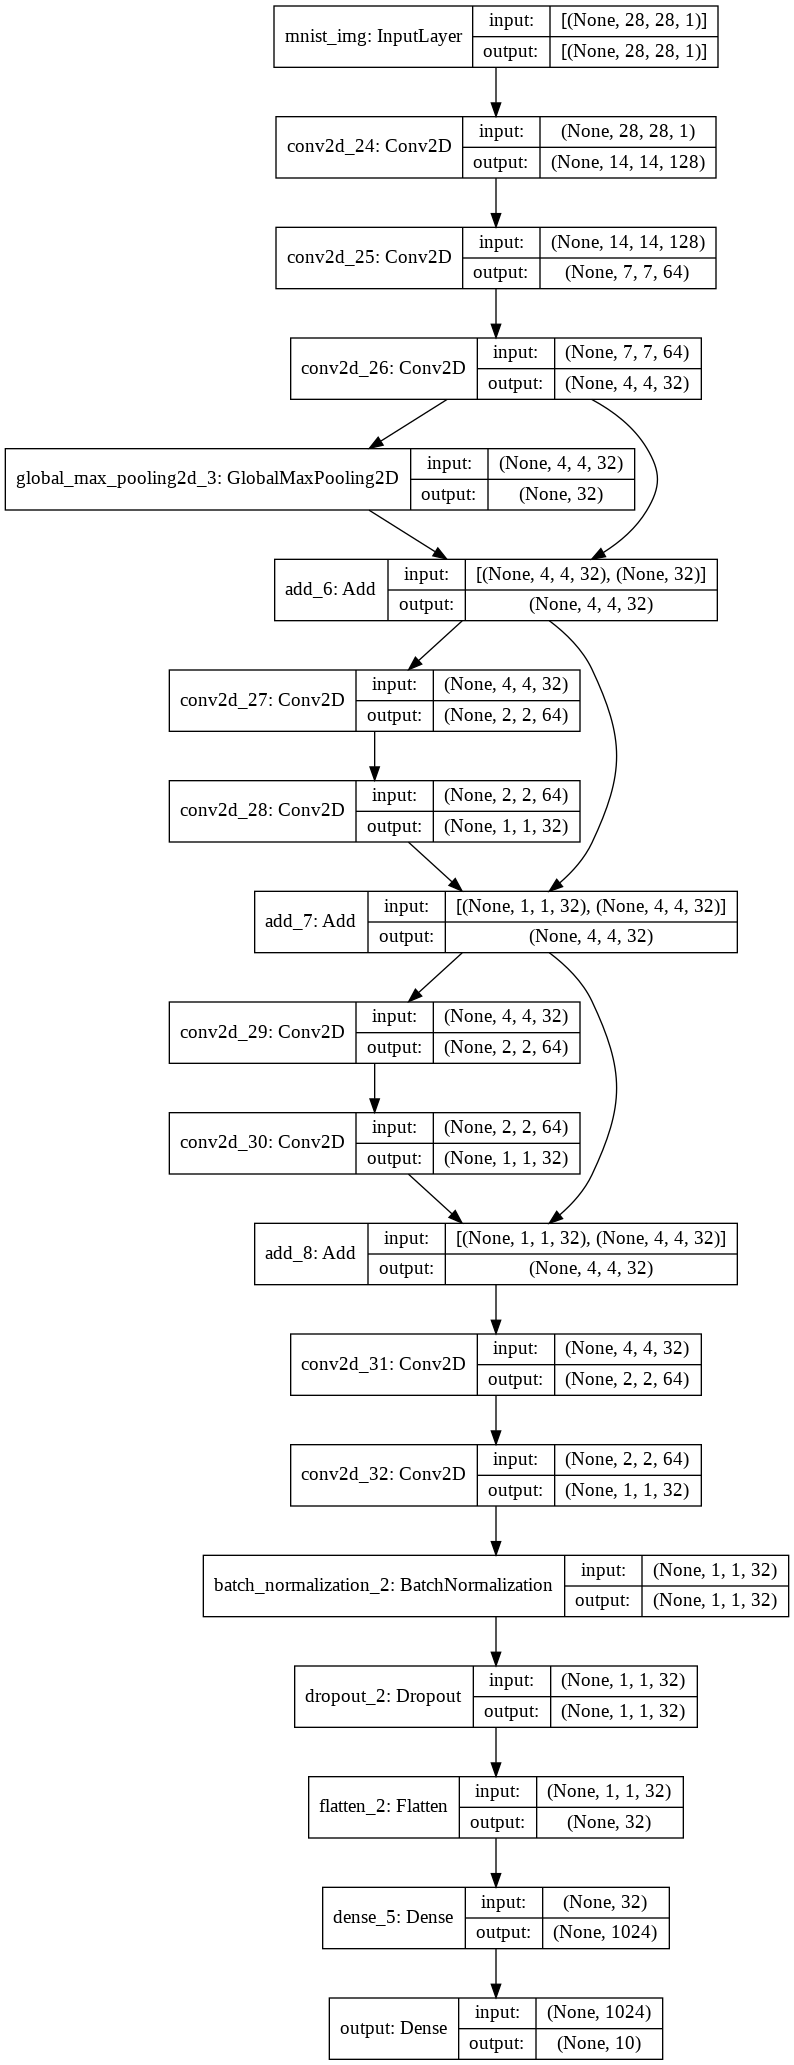

In [54]:
inputs = tf.keras.Input(shape = (28,28,1), name = 'mnist_img')
x = layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same', strides = (2,2))(inputs)
x = layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', strides = (2,2))(x)
x = layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same', strides = (2,2))(x)
out = layers.GlobalMaxPooling2D()(x)
block1 = layers.add([x, out])

x = layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', strides = (2,2))(block1)
x = layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same', strides = (2,2))(x)
block2 = layers.add([x, block1])

x = layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', strides = (2,2))(block2)
x = layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same', strides = (2,2))(x)
block3 = layers.add([x, block2])

x = layers.Conv2D(filters = 64, kernel_size = (3,3), activation ='relu',padding = 'same', strides = (2,2))(block3)
x = layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same', strides = (2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate = 0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation = 'relu')(x)
outputs = layers.Dense(units = 10, activation = 'softmax', name = 'output')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'ResNet')
model.summary()
tf.keras.utils.plot_model(model = model, to_file = 'ResNet.png', show_shapes = True)

In [17]:
#Load the data from keras and preprocessing it

In [64]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [65]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [66]:
x_train, x_test = x_train.reshape(60000, 28,28,1).astype('float32')/255.0, x_test.reshape(10000, 28,28,1).astype('float32')/255.0

In [67]:
y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes = 10), tf.keras.utils.to_categorical(y_test, num_classes = 10)

In [68]:
print(f"x_train_shape: {x_train.shape}, y_train_shape: {y_train.shape}\nx_test_shape: {x_test.shape}, y_test_shape: {y_test.shape}")

x_train_shape: (60000, 28, 28, 1), y_train_shape: (60000, 10)
x_test_shape: (10000, 28, 28, 1), y_test_shape: (10000, 10)


In [69]:
#Change to tensorflow data format

In [70]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(buffer_size = 1024).batch(64)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [71]:
#Getting the loss, metrics, and optimizer

In [72]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
train_metric_fn = tf.keras.metrics.CategoricalAccuracy()
test_metric_fn = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3)

In [73]:
#The training loop from scratch

In [74]:
#decorate to allow eager excecution
@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    output = model(x, training = True)
    loss = loss_fn(y, output)
  grads = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  train_metric_fn.update_state(y, output)
  return loss

In [75]:
@tf.function
def test_step(x, y):
  with tf.GradientTape() as tape:
    val_logits = model(x, training = False)
    test_metric_fn.update_state(y, val_logits)

In [76]:
#Now we can use the above decorated function to train our model from scratch as follow

In [77]:
epochs = 5
tic = time.time()
for epoch in range(epochs):
  print(f"The starting of epoch: {epoch}")
  for step, (x_train_batch, y_train_batch) in enumerate(train_data):
    train_loss = train_step(x_train_batch, y_train_batch)
    train_acc = train_metric_fn.result()
    if step % 100 == 0:
      print(f"The training loss at epoch {epoch} is : {train_loss:.4f}")
      print(f"The training accuracy at epoch {epoch} is : {train_acc:.4f}")
      train_metric_fn.reset_states()
  for x_val_batch, y_val_batch in test_data:
    test_step(x_val_batch, y_val_batch)
  val_acc = test_metric_fn.result()
  test_metric_fn.reset_states()
  print(f"Validation accuracy is: {val_acc:.4f}")

toc = time.time()
print(f"time elapsed is : {time_fmt(toc - tic)}")
  

The starting of epoch: 0
The training loss at epoch 0 is : 2.3066
The training accuracy at epoch 0 is : 0.0781
The training loss at epoch 0 is : 0.7030
The training accuracy at epoch 0 is : 0.6947
The training loss at epoch 0 is : 0.2535
The training accuracy at epoch 0 is : 0.8508
The training loss at epoch 0 is : 0.2569
The training accuracy at epoch 0 is : 0.8905
The training loss at epoch 0 is : 0.4903
The training accuracy at epoch 0 is : 0.9112
The training loss at epoch 0 is : 0.1718
The training accuracy at epoch 0 is : 0.9094
The training loss at epoch 0 is : 0.2680
The training accuracy at epoch 0 is : 0.9202
The training loss at epoch 0 is : 0.1652
The training accuracy at epoch 0 is : 0.9141
The training loss at epoch 0 is : 0.2170
The training accuracy at epoch 0 is : 0.9119
The training loss at epoch 0 is : 0.1621
The training accuracy at epoch 0 is : 0.9236
Validation accuracy is: 0.8401
The starting of epoch: 1
The training loss at epoch 1 is : 0.2471
The training accur